In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from matplotlib.colors import Normalize

#from xxx import *

# Fonctions pour le calcul de la complexité

In [ ]:
def mfcc_complexity(n,W,m,f,k):
  # Paramètres pour la complexité
  # n Nombre d'échantillons (environ 1s)
  # W Taille de la fenêtre
  # m Nombre de filtres Mel
  # f Nombre de fenêtres temporelles
  # k nombre de mfcc
  result = n * W * np.log2(W) + m * f + k * m
  return result

# Fonction de calcul de la complexité pour les combinaisons
def combinaison_complexity(selected_features,num_mel_filters, num_mfccs, num_windows, window_size):
    complexity = 0
    for feature in selected_features:
        if feature == 'MFCC':
            # Complexité des MFCC : FFT + Mel filters + DCT
            complexity += num_windows * (window_size * np.log2(window_size) + num_mel_filters + num_mfccs * num_mel_filters)
        elif feature == 'Energy':
            # Complexité pour Energy : somme simple
            complexity += num_windows * 1  # O(W) -> simplifié à un coût constant par fenêtre
        elif feature == 'Tonnetz':
            # Complexité pour Tonnetz
            complexity += num_windows * window_size
        elif feature == 'FFT':
            # FFT seule
            complexity += num_windows * (window_size * np.log2(window_size))
        elif feature == 'Chroma':
            # Chroma : FFT + regroupement chromatique
            complexity += num_windows * (window_size * np.log2(window_size) + 12)  # 12 classes chromatiques
        elif feature == 'STFT':
            # STFT : FFT par fenêtre (avec overlapping)
            complexity += num_windows * (window_size * np.log2(window_size))
    return complexity

# Fonctions de complexité pour les classifier
# 2. SVM
def svm_linear_complexity(n, d):
    return n * d

def svm_kernel_complexity(n, d):
    return n**2 * d + n**3

# 3. Light GBM
def lightgbm_training_complexity(n, m, d, T=100):
    return T * n * np.log(n) * d

def lightgbm_prediction_complexity(n, d, T=100):
    return T * n * d

# 4. Random Forest
def rf_training_complexity(n, m, d, T=100):
    return T * n * m * d

def rf_prediction_complexity(n, d, T=100):
    return n * T * d

# 5. XGBoost
def xgboost_training_complexity(n, m, d, T=100):
    return T * (n * m * np.log(n) + 2**d)

def xgboost_prediction_complexity(n, d, T=100):
    return n * T * d



### Chemain vers un fichier son type

In [ ]:
# Chemin du dossier contenant les fichiers audio
single_file_path = '/content/drive/MyDrive/PER/Data/sounds/xxx.wav'

## Analyse des paramètres du signal

In [ ]:
y, sr = librosa.load(single_file_path, sr=None)  # sr=None conserve la fréquence d'échantillonnage d'origine

# Calcul des caractéristiques du signal
n = len(y)                  # Nombre d'échantillons
duration = n / sr           # Durée totale du signal en secondes
W = 2048                    # Taille de la fenêtre typique pour la STFT
f = int(n / W)              # Nombre de fenêtres temporelles (frames) pour une analyse STFT

# Affichage des caractéristiques
print(f"Fréquence d'échantillonnage (Hz) : {sr}")
print(f"Nombre total d'échantillons : {n}")
print(f"Durée totale du signal (secondes) : {duration:.2f}")
print(f"Taille de la fenêtre (STFT) : {W}")
print(f"Nombre de fenêtres temporelles (frames) : {f}")

Fréquence d'échantillonnage (Hz) : 64000
Nombre total d'échantillons : 64000
Durée totale du signal (secondes) : 1.00
Taille de la fenêtre (STFT) : 2048
Nombre de fenêtres temporelles (frames) : 31


# Méthode BIG O

In [ ]:
# Paramètres pour la complexité
n = 64000  # Nombre d'échantillons (environ 1s)
W = 2048   # Taille de la fenêtre
m = 20     # Nombre de filtres Mel
f = int(n / W)  # Nombre de fenêtres temporelles

### Complexité Extraction des MFCC

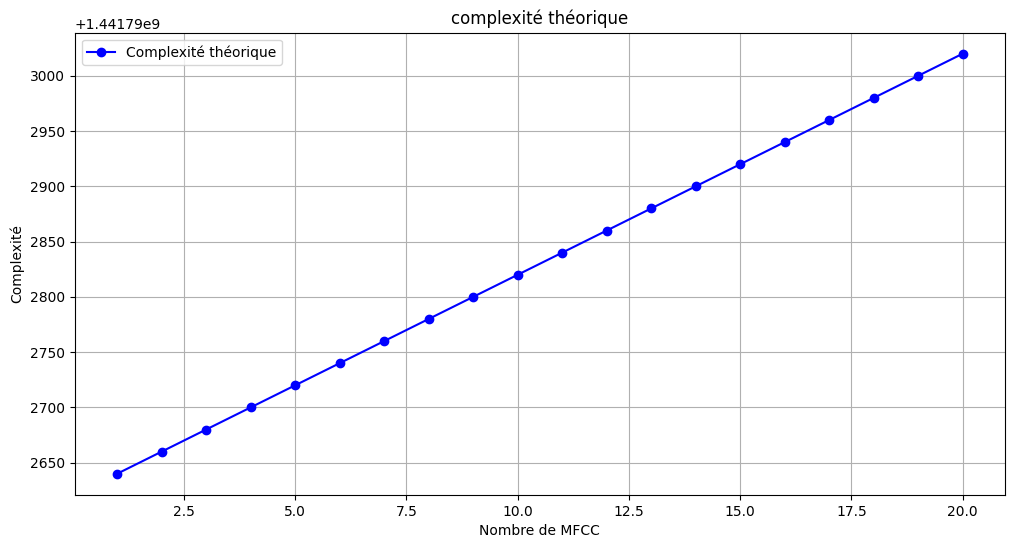

In [ ]:
# Fichier audio d'exemple
file_path = '/content/drive/MyDrive/PER/Data/sounds/whale_MAY045_channelA_2022-08-20_21-09-46_367sec.wav'


# Listes pour stocker les résultats
n_mfccs = range(1, 21)
complexities = []
execution_times = []

# Calcul des complexités théoriques et des temps d'exécution
for k in n_mfccs: #k = nombre de mfcc
    # Calcul de la complexité théorique
    complexity = mfcc_complexity(n,W,m,f,k)# n * W * np.log2(W) + m * f + k * m#
    complexities.append(complexity)

# Tracer le graphique
plt.figure(figsize=(12, 6))

# Courbe des complexités théoriques
plt.plot(n_mfccs, complexities, label="Complexité théorique", color='blue', marker='o')

# Courbe des temps d'exécution réels
#plt.plot(n_mfccs, execution_times, label="Temps d'exécution réel", color='red', marker='x')

plt.xlabel('Nombre de MFCC')
plt.ylabel('Complexité')
plt.title('complexité théorique')
plt.legend()
plt.grid()
plt.show()


###Complexité & Combinaison de features

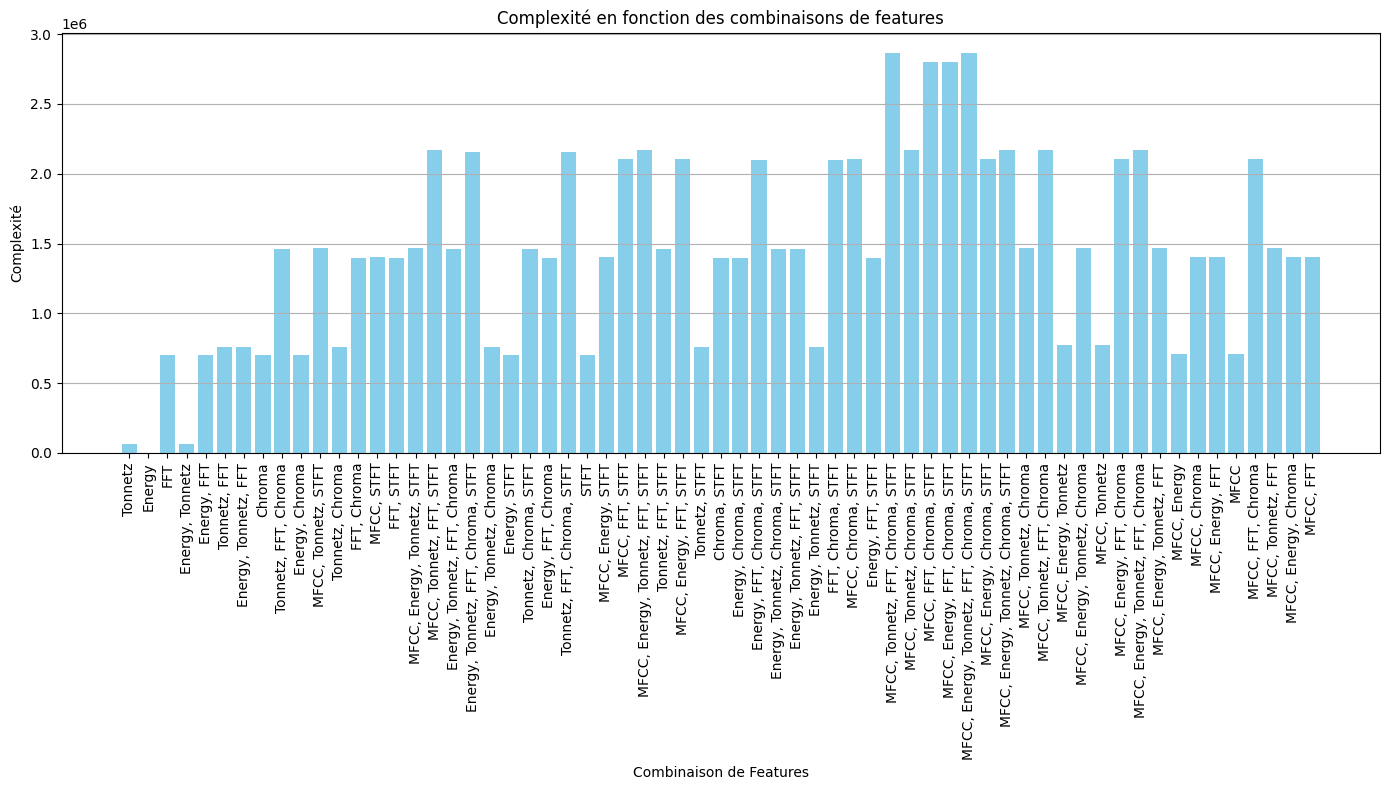

In [ ]:
# Paramètres pour la simulation
n_samples = 64000  # Nombre total d'échantillons (1s à 64 kHz)
window_size = 2048  # Taille de la fenêtre
num_windows = int(n_samples / window_size)  # Nombre de fenêtres temporelles
num_mfccs = 13  # Nombre de MFCCs extraits
num_mel_filters = 20  # Nombre de filtres Mel
feature_names = ['MFCC', 'Energy', 'Tonnetz', 'FFT', 'Chroma', 'STFT']

combinations = [('Tonnetz',), ('Energy',), ('FFT',), ('Energy', 'Tonnetz'), ('Energy', 'FFT'), ('Tonnetz', 'FFT'), ('Energy', 'Tonnetz', 'FFT'), ('Chroma',), ('Tonnetz', 'FFT', 'Chroma'), ('Energy', 'Chroma'), ('MFCC', 'Tonnetz', 'STFT'), ('Tonnetz', 'Chroma'), ('FFT', 'Chroma'), ('MFCC', 'STFT'), ('FFT', 'STFT'), ('MFCC', 'Energy', 'Tonnetz', 'STFT'), ('MFCC', 'Tonnetz', 'FFT', 'STFT'), ('Energy', 'Tonnetz', 'FFT', 'Chroma'), ('Energy', 'Tonnetz', 'FFT', 'Chroma', 'STFT'), ('Energy', 'Tonnetz', 'Chroma'), ('Energy', 'STFT'), ('Tonnetz', 'Chroma', 'STFT'), ('Energy', 'FFT', 'Chroma'), ('Tonnetz', 'FFT', 'Chroma', 'STFT'), ('STFT',), ('MFCC', 'Energy', 'STFT'), ('MFCC', 'FFT', 'STFT'), ('MFCC', 'Energy', 'Tonnetz', 'FFT', 'STFT'), ('Tonnetz', 'FFT', 'STFT'), ('MFCC', 'Energy', 'FFT', 'STFT'), ('Tonnetz', 'STFT'), ('Chroma', 'STFT'), ('Energy', 'Chroma', 'STFT'), ('Energy', 'FFT', 'Chroma', 'STFT'), ('Energy', 'Tonnetz', 'Chroma', 'STFT'), ('Energy', 'Tonnetz', 'FFT', 'STFT'), ('Energy', 'Tonnetz', 'STFT'), ('FFT', 'Chroma', 'STFT'), ('MFCC', 'Chroma', 'STFT'), ('Energy', 'FFT', 'STFT'), ('MFCC', 'Tonnetz', 'FFT', 'Chroma', 'STFT'), ('MFCC', 'Tonnetz', 'Chroma', 'STFT'), ('MFCC', 'FFT', 'Chroma', 'STFT'), ('MFCC', 'Energy', 'FFT', 'Chroma', 'STFT'), ('MFCC', 'Energy', 'Tonnetz', 'FFT', 'Chroma', 'STFT'), ('MFCC', 'Energy', 'Chroma', 'STFT'), ('MFCC', 'Energy', 'Tonnetz', 'Chroma', 'STFT'), ('MFCC', 'Tonnetz', 'Chroma'), ('MFCC', 'Tonnetz', 'FFT', 'Chroma'), ('MFCC', 'Energy', 'Tonnetz'), ('MFCC', 'Energy', 'Tonnetz', 'Chroma'), ('MFCC', 'Tonnetz'), ('MFCC', 'Energy', 'FFT', 'Chroma'), ('MFCC', 'Energy', 'Tonnetz', 'FFT', 'Chroma'), ('MFCC', 'Energy', 'Tonnetz', 'FFT'), ('MFCC', 'Energy'), ('MFCC', 'Chroma'), ('MFCC', 'Energy', 'FFT'), ('MFCC',), ('MFCC', 'FFT', 'Chroma'), ('MFCC', 'Tonnetz', 'FFT'), ('MFCC', 'Energy', 'Chroma'), ('MFCC', 'FFT')]

# Initialiser les listes pour les résultats
complexities = []

# Calculer la complexité pour chaque combinaison
for combo in combinations:
    complexity = combinaison_complexity(combo,num_mel_filters, num_mfccs, num_windows, window_size)
    complexities.append((combo, complexity))

# Créer un DataFrame Pandas pour les résultats
df_complexity = pd.DataFrame(complexities, columns=['Feature Combination', 'Complexity'])

# Trier les combinaisons par complexité
#df_complexity = df_complexity.sort_values(by='Complexity')

# Tracer les résultats
plt.figure(figsize=(14, 8))
plt.bar(
    df_complexity['Feature Combination'].apply(lambda x: ', '.join(x)),
    df_complexity['Complexity'],
    color='skyblue'
)
plt.ylabel('Complexité')
plt.xlabel('Combinaison de Features')
plt.title('Complexité en fonction des combinaisons de features')
plt.xticks(rotation=90)  # Rotation pour mieux afficher les combinaisons
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


### Comparaison complexité des classifiers

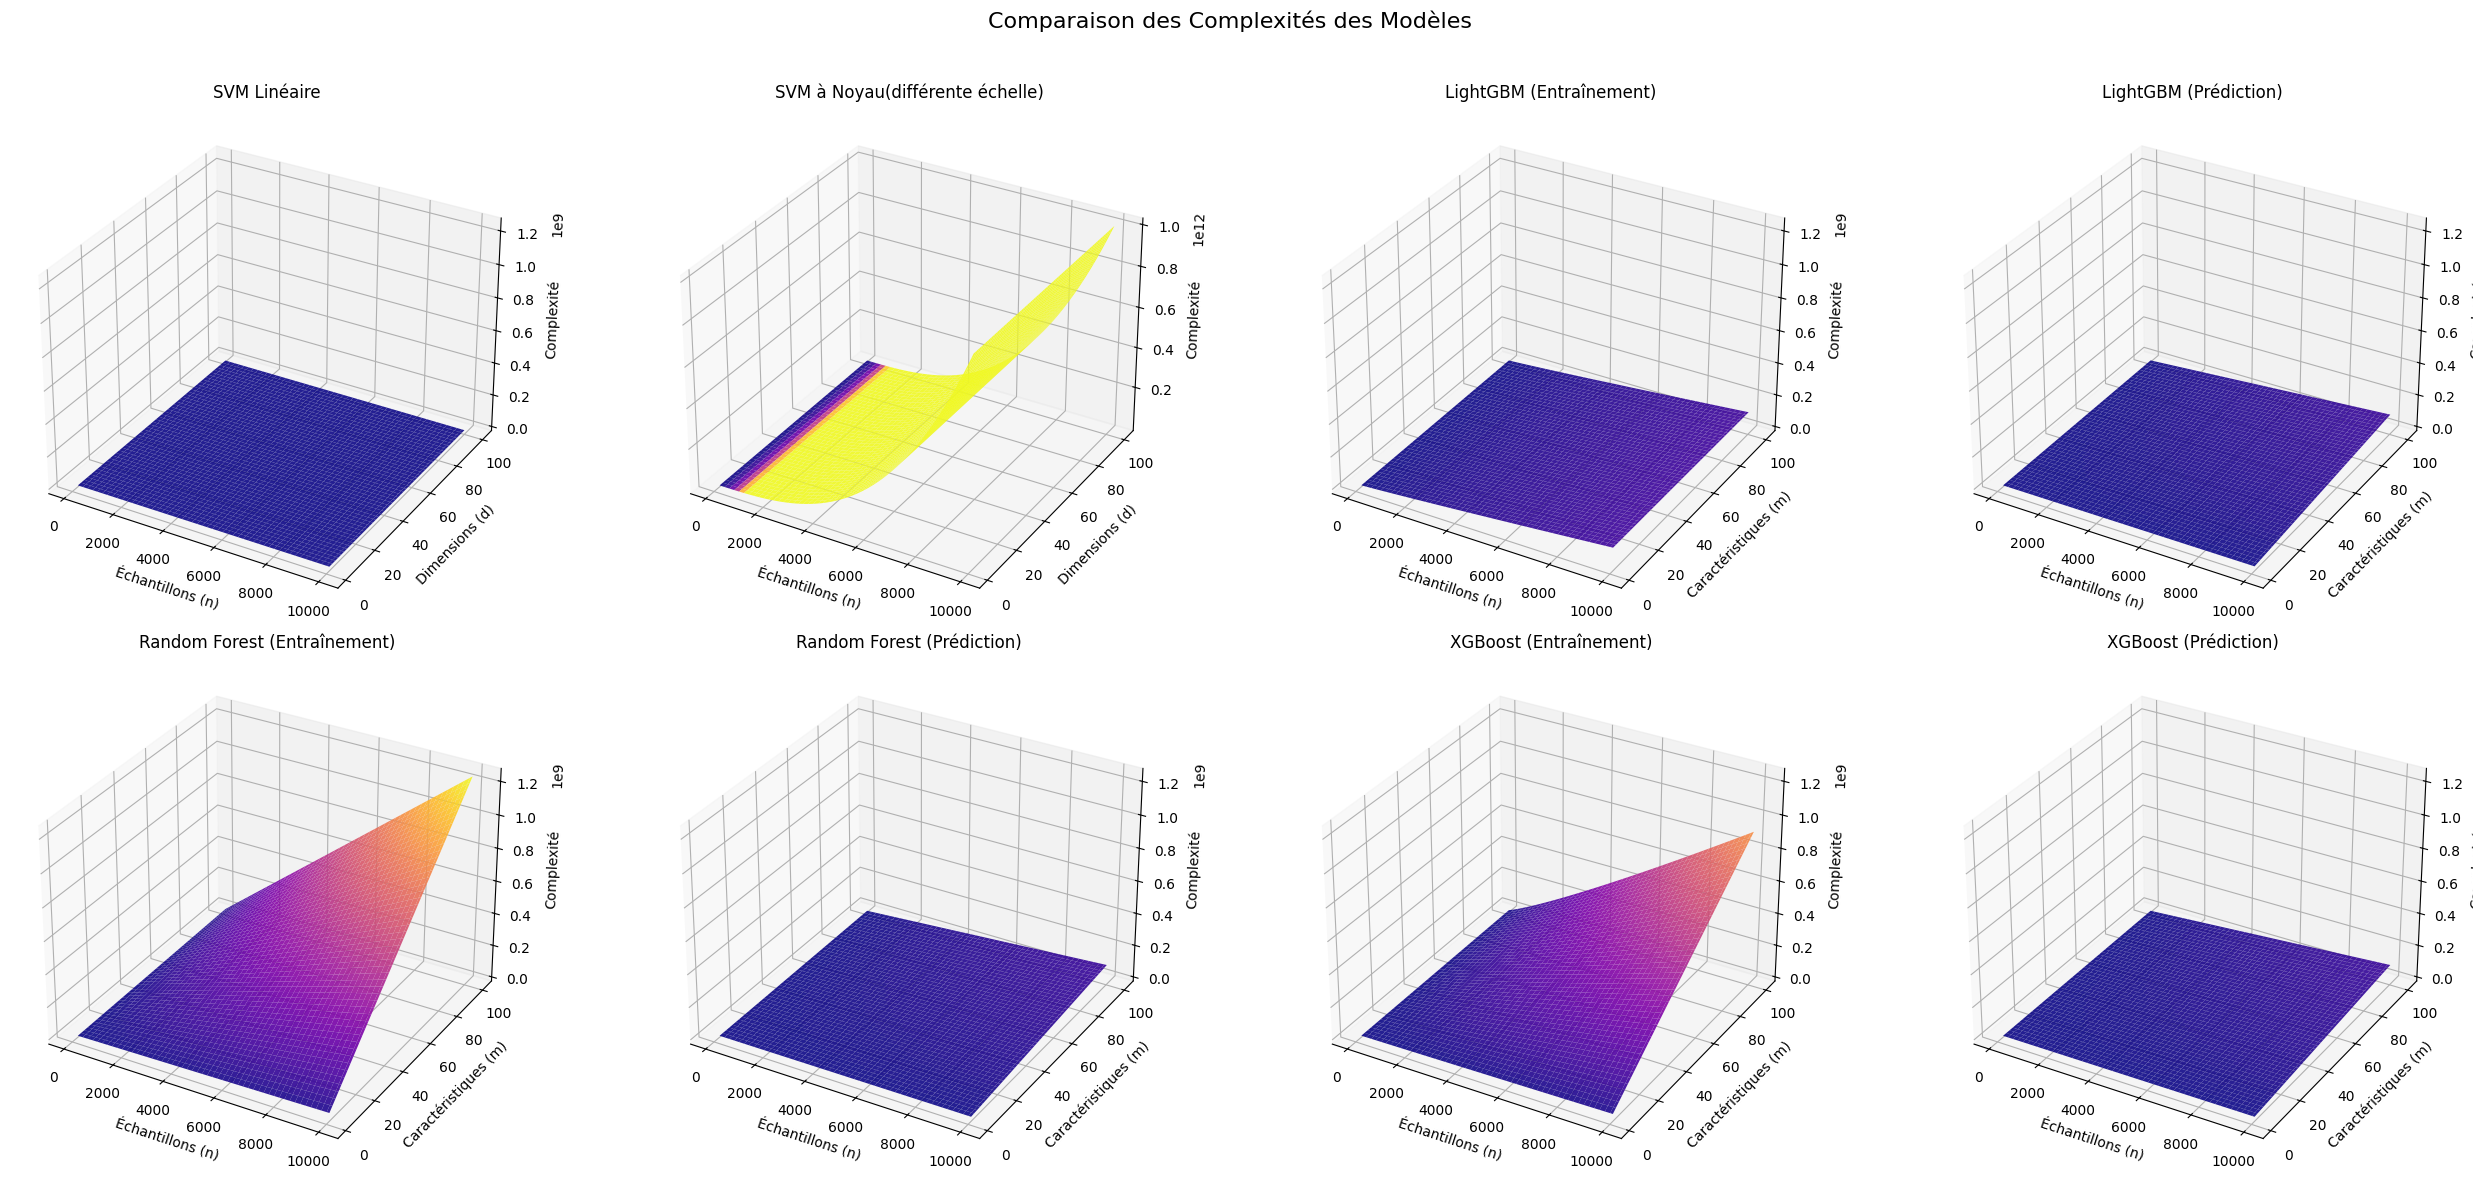

In [ ]:
# Paramètres
n_samples = np.linspace(100, 10000, 100)  # Nombre d'échantillons (n)
n_features = np.linspace(2, 100, 50)      # Nombre de caractéristiques (m ou d)
tree_depth = np.linspace(5, 20, 4)        # Profondeur des arbres
n_trees = 100                             # Nombre d'arbres
lda_dimensions = np.linspace(2, 100, 50)  # Dimensions pour LDA


# Grille pour visualisation
N, D = np.meshgrid(n_samples, n_features)

# Calculs pour chaque modèle
svm_linear_comp = svm_linear_complexity(N, D)
svm_kernel_comp = svm_kernel_complexity(N, D)

lightgbm_comp = lightgbm_training_complexity(N, D, np.mean(tree_depth), n_trees)
lightgbm_pred = lightgbm_prediction_complexity(N, D, n_trees)

rf_comp = rf_training_complexity(N, D, np.mean(tree_depth), n_trees)
rf_pred = rf_prediction_complexity(N, D, n_trees)

xgboost_comp = xgboost_training_complexity(N, D, np.mean(tree_depth), n_trees)
xgboost_pred = xgboost_prediction_complexity(N, D, n_trees)

# Définir les mêmes limites pour tous les graphes
z_min = 0
z_max = max( np.max(lightgbm_comp), np.max(rf_comp), np.max(xgboost_comp))

norm = Normalize(vmin=z_min, vmax=z_max)
# Visualisation
fig, axs = plt.subplots(2, 4, figsize=(26, 12), subplot_kw={'projection': '3d'})
fig.suptitle("Comparaison des Complexités des Modèles", fontsize=16)

# SVM Linéaire
axs[0, 0].plot_surface(N, D, svm_linear_comp, cmap='plasma',norm=norm, alpha=0.9)
axs[0, 0].set_title("SVM Linéaire")
axs[0, 0].set_xlabel("Échantillons (n)")
axs[0, 0].set_ylabel("Dimensions (d)")
axs[0, 0].set_zlabel("Complexité")
axs[0, 0].set_zlim(z_min, z_max)

# SVM Kernel
axs[0, 1].plot_surface(N, D, svm_kernel_comp, cmap='plasma',norm=norm, alpha=0.9)
axs[0, 1].set_title("SVM à Noyau(différente échelle)")
axs[0, 1].set_xlabel("Échantillons (n)")
axs[0, 1].set_ylabel("Dimensions (d)")
axs[0, 1].set_zlabel("Complexité")
#axs[0, 1].set_zlim(z_min, z_max)

# LightGBM (Entraînement)
axs[0, 2].plot_surface(N, D, lightgbm_comp, cmap='plasma',norm=norm, alpha=0.9)
axs[0, 2].set_title("LightGBM (Entraînement)")
axs[0, 2].set_xlabel("Échantillons (n)")
axs[0, 2].set_ylabel("Caractéristiques (m)")
axs[0, 2].set_zlabel("Complexité")
axs[0, 2].set_zlim(z_min, z_max)

# LightGBM (Prédiction)
axs[0, 3].plot_surface(N, D, lightgbm_pred, cmap='plasma',norm=norm, alpha=0.9)
axs[0, 3].set_title("LightGBM (Prédiction)")
axs[0, 3].set_xlabel("Échantillons (n)")
axs[0, 3].set_ylabel("Caractéristiques (m)")
axs[0, 3].set_zlabel("Complexité")
axs[0, 3].set_zlim(z_min, z_max)

# Random Forest (Entraînement)
axs[1, 0].plot_surface(N, D, rf_comp, cmap='plasma',norm=norm, alpha=0.9)
axs[1, 0].set_title("Random Forest (Entraînement)")
axs[1, 0].set_xlabel("Échantillons (n)")
axs[1, 0].set_ylabel("Caractéristiques (m)")
axs[1, 0].set_zlabel("Complexité")
axs[1, 0].set_zlim(z_min, z_max)

# Random Forest (Prédiction)
axs[1, 1].plot_surface(N, D, rf_pred, cmap='plasma',norm=norm, alpha=0.9)
axs[1, 1].set_title("Random Forest (Prédiction)")
axs[1, 1].set_xlabel("Échantillons (n)")
axs[1, 1].set_ylabel("Caractéristiques (m)")
axs[1, 1].set_zlabel("Complexité")
axs[1, 1].set_zlim(z_min, z_max)

# XGBoost (Entraînement)
axs[1, 2].plot_surface(N, D, xgboost_comp, cmap='plasma',norm=norm, alpha=0.9)
axs[1, 2].set_title("XGBoost (Entraînement)")
axs[1, 2].set_xlabel("Échantillons (n)")
axs[1, 2].set_ylabel("Caractéristiques (m)")
axs[1, 2].set_zlabel("Complexité")
axs[1, 2].set_zlim(z_min, z_max)

# XGBoost (Prédiction)
axs[1, 3].plot_surface(N, D, xgboost_pred, cmap='plasma',norm=norm, alpha=0.9)
axs[1, 3].set_title("XGBoost (Prédiction)")
axs[1, 3].set_xlabel("Échantillons (n)")
axs[1, 3].set_ylabel("Caractéristiques (m)")
axs[1, 3].set_zlabel("Complexité")
axs[1, 3].set_zlim(z_min, z_max)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Ajuste pour le titre
plt.show()
